In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f


In [2]:
import pyspark
print(pyspark.__version__)

4.1.1


In [3]:
import os, sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable


In [4]:
print("PYSPARK_PYTHON =", os.environ.get("PYSPARK_PYTHON"))
print("PYSPARK_DRIVER_PYTHON =", os.environ.get("PYSPARK_DRIVER_PYTHON"))

PYSPARK_PYTHON = c:\Users\Piotr\anaconda3\envs\BigData\python.exe
PYSPARK_DRIVER_PYTHON = c:\Users\Piotr\anaconda3\envs\BigData\python.exe


## Initializing Spark and loading dataset

In [5]:
# Initialize Spark and read CSV
spark = SparkSession.builder.master("local[*]").appName("StellarClassifier") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.port", "0") \
    .getOrCreate()

csv_path = "star_classification_org.csv"

# Read CSV with header and inferred schema
df = spark.read.csv(csv_path, header=True, inferSchema=True)

# Basic checks and preview
try:
    row_count = df.count()
except Exception as e:
    print("Could not count rows:", e)
    row_count = None

print(f"Loaded rows: {row_count} (path: {csv_path})")
df.printSchema()
df.show(10, truncate=False)


Loaded rows: 100000 (path: star_classification_org.csv)
root
 |-- obj_ID: double (nullable = true)
 |-- alpha: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- run_ID: integer (nullable = true)
 |-- rerun_ID: integer (nullable = true)
 |-- cam_col: integer (nullable = true)
 |-- field_ID: integer (nullable = true)
 |-- spec_obj_ID: double (nullable = true)
 |-- class: string (nullable = true)
 |-- redshift: double (nullable = true)
 |-- plate: integer (nullable = true)
 |-- MJD: integer (nullable = true)
 |-- fiber_ID: integer (nullable = true)

+---------------------+----------------+------------------+--------+--------+--------+--------+--------+------+--------+-------+--------+---------------------+------+------------+-----+-----+--------+
|obj_ID               |alpha           |delta             |u    

Checking for duplicates

In [6]:
df.select('obj_ID').distinct().count()

80846

In [7]:
df.describe().show()

+-------+--------------------+-------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+
|summary|              obj_ID|              alpha|            delta|                u|                 g|                 r|                 i|                 z|           run_ID|rerun_ID|           cam_col|          field_ID|         spec_obj_ID| class|          redshift|             plate|               MJD|         fiber_ID|
+-------+--------------------+-------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+
|  coun

## Dropping duplicate entries

In [8]:
df_unique = df.drop_duplicates(['obj_ID'])

In [9]:
df_unique.describe().show()

+-------+--------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+
|summary|              obj_ID|              alpha|             delta|                 u|                g|                 r|                 i|                 z|           run_ID|rerun_ID|           cam_col|          field_ID|         spec_obj_ID| class|          redshift|             plate|               MJD|         fiber_ID|
+-------+--------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+--------+------------------+------------------+--------------------+------+------------------+------------------+------------------+-----------------+
|  c

## Choosing relevant features

In [10]:
df.printSchema()

root
 |-- obj_ID: double (nullable = true)
 |-- alpha: double (nullable = true)
 |-- delta: double (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- run_ID: integer (nullable = true)
 |-- rerun_ID: integer (nullable = true)
 |-- cam_col: integer (nullable = true)
 |-- field_ID: integer (nullable = true)
 |-- spec_obj_ID: double (nullable = true)
 |-- class: string (nullable = true)
 |-- redshift: double (nullable = true)
 |-- plate: integer (nullable = true)
 |-- MJD: integer (nullable = true)
 |-- fiber_ID: integer (nullable = true)



Dorzucić analize

u , g, r, i, z --

In [10]:
features = ["u", "g", "r", "i", "z"]
target = "class"
df_model = df_unique.select(target, *features)

In [11]:
df_model.show(5)

+------+--------+--------+--------+--------+--------+
| class|       u|       g|       r|       i|       z|
+------+--------+--------+--------+--------+--------+
|  STAR|20.79859|19.54183|19.04607|18.82743|18.74658|
|GALAXY|22.81235|21.48987|20.04629|19.59547|18.99735|
|GALAXY|22.44247|20.96329|20.00247|19.47096|19.38536|
|  STAR|23.17228|20.57825|19.14963|18.55397|18.15417|
|  STAR|19.84112|18.31459|17.70017|17.45584|17.36307|
+------+--------+--------+--------+--------+--------+
only showing top 5 rows


In [12]:
df_model.describe().show()

+-------+------+-----------------+-----------------+------------------+------------------+------------------+
|summary| class|                u|                g|                 r|                 i|                 z|
+-------+------+-----------------+-----------------+------------------+------------------+------------------+
|  count| 80846|            80846|            80846|             80846|             80846|             80846|
|   mean|  NULL|22.03626660490306|20.56915997155085|19.680593774212685| 19.10138325066171|18.652676720468605|
| stddev|  NULL|35.31733838847741|35.29880571367334|1.8561936364500249|1.7487185806570844|35.275939913258085|
|    min|GALAXY|          -9999.0|          -9999.0|           9.82207|          9.469903|           -9999.0|
|    max|  STAR|         30.66039|         31.60224|          29.57186|          30.25009|          28.23829|
+-------+------+-----------------+-----------------+------------------+------------------+------------------+



## Visualizing features in Pandas

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df_model_pd = df_model.toPandas()

In [16]:
for name in features:
    print(f"{name} bounds: {df_model_pd[name].min(), df_model_pd[name].max()}")

u bounds: (np.float64(-9999.0), np.float64(30.66039))
g bounds: (np.float64(-9999.0), np.float64(31.60224))
r bounds: (np.float64(9.82207), np.float64(29.57186))
i bounds: (np.float64(9.469903), np.float64(30.25009))
z bounds: (np.float64(-9999.0), np.float64(28.23829))


### Verifying data distribution in Pandas

In [17]:
df_model_pd[features] = df_model_pd[features].replace(-9999.0, float("nan"))

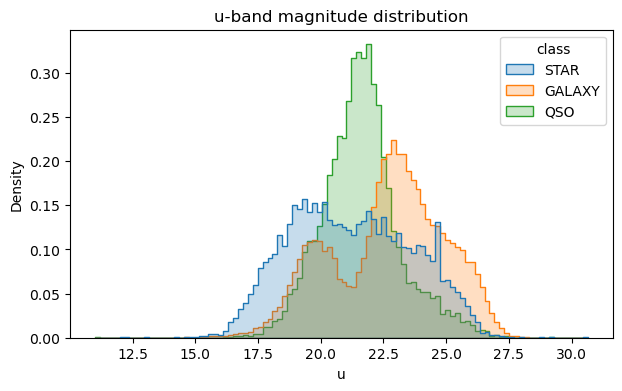

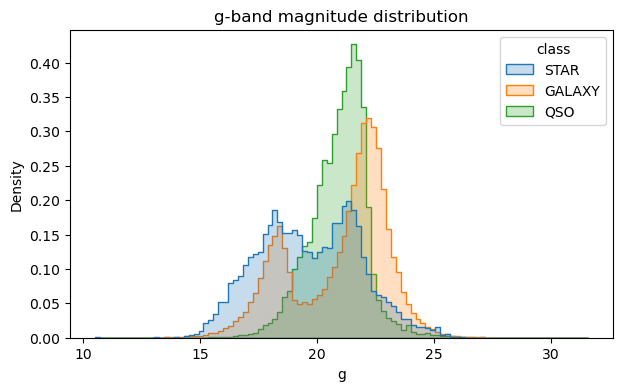

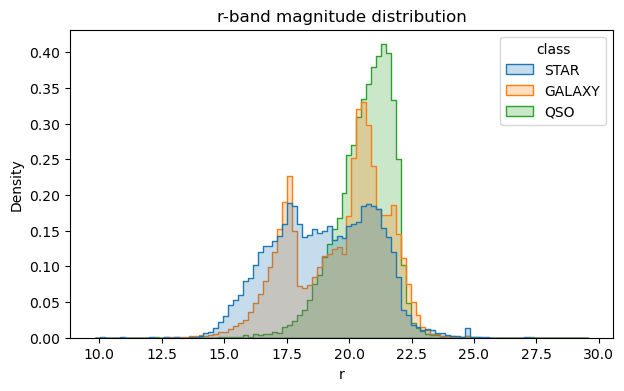

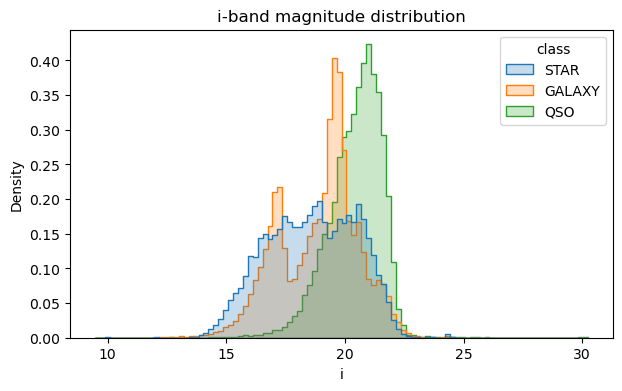

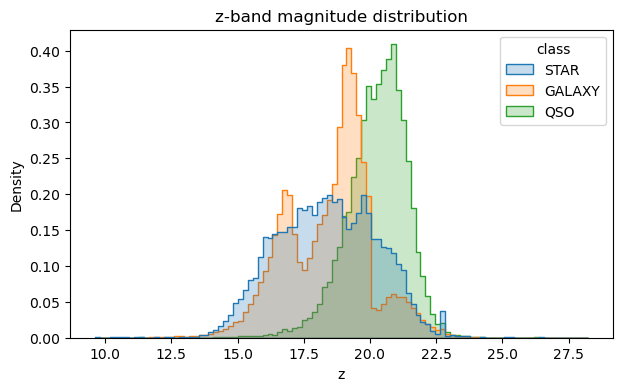

In [18]:
for name in features:
    plt.figure(figsize=(7,4))
    sns.histplot(
        data=df_model_pd,
        x=name,
        hue="class",
        bins=100,
        element="step",
        stat="density",
        common_norm=False
    )
    plt.title(f"{name}-band magnitude distribution")
    plt.show()

## Filtering the data

In [13]:
bad_value = -9999.0

df_model_clean = df_model.filter(
    " AND ".join([f"{c} != {bad_value}" for c in features])
)

In [20]:
df_model_clean.describe().show()

+-------+------+------------------+------------------+-----------------+------------------+------------------+
|summary| class|                 u|                 g|                r|                 i|                 z|
+-------+------+------------------+------------------+-----------------+------------------+------------------+
|  count| 80845|             80845|             80845|            80845|             80845|             80845|
|   mean|  NULL| 22.16022029735905|20.693095516853216|19.68061251369905|19.101396666868656|18.776588560121294|
| stddev|  NULL|2.2703838016516635| 2.051733249314542|1.856197468926587|1.7487252352653393|1.7523836424184578|
|    min|GALAXY|          10.99623|           10.4982|          9.82207|          9.469903|          9.612333|
|    max|  STAR|          30.66039|          31.60224|         29.57186|          30.25009|          28.23829|
+-------+------+------------------+------------------+-----------------+------------------+------------------+



## Adding additional features (colors)

In [14]:
from pyspark.sql.functions import col

df_model_clean = df_model_clean.withColumn("u_g", col("u") - col("g")) \
       .withColumn("g_r", col("g") - col("r")) \
       .withColumn("r_i", col("r") - col("i")) \
       .withColumn("i_z", col("i") - col("z"))

features.extend(["u_g", "g_r", "r_i", "i_z"])

In [22]:
df_model_clean.describe().show()

+-------+------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|summary| class|                 u|                 g|                r|                 i|                 z|               u_g|               g_r|                r_i|                i_z|
+-------+------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|  count| 80845|             80845|             80845|            80845|             80845|             80845|             80845|             80845|              80845|              80845|
|   mean|  NULL| 22.16022029735905|20.693095516853216|19.68061251369905|19.101396666868656|18.776588560121294| 1.467124780505902|1.0124830031541845| 0.5792158468303557|0.32480810674748073|
| stddev|  NULL|2.2703838016516635| 2.051733249314542|1

In [23]:
df_model_clean.printSchema()

root
 |-- class: string (nullable = true)
 |-- u: double (nullable = true)
 |-- g: double (nullable = true)
 |-- r: double (nullable = true)
 |-- i: double (nullable = true)
 |-- z: double (nullable = true)
 |-- u_g: double (nullable = true)
 |-- g_r: double (nullable = true)
 |-- r_i: double (nullable = true)
 |-- i_z: double (nullable = true)



## Plotting the correlation matrix

In [24]:
df_model_clean_pd = df_model_clean.select(features).toPandas()

In [25]:
corr = df_model_clean_pd.corr()

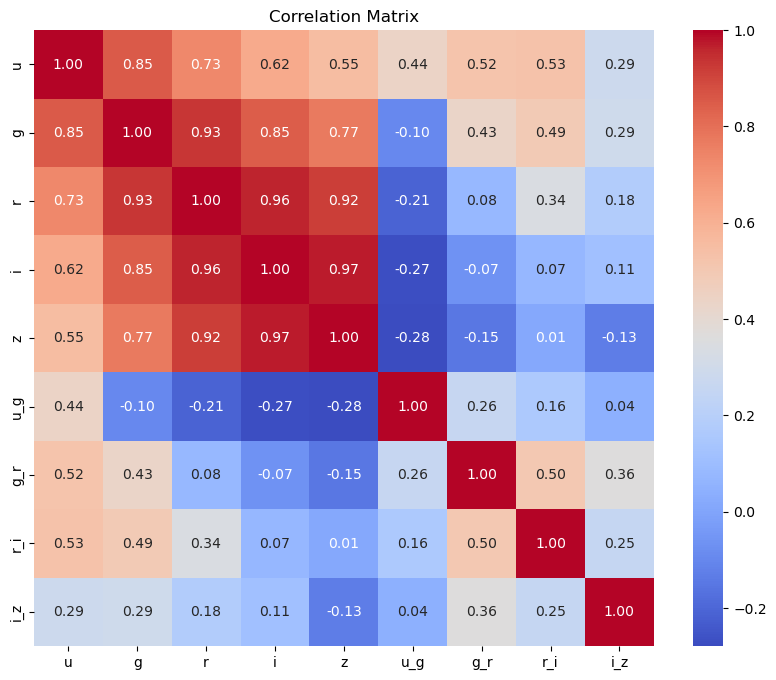

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Saving the cleaned dataset

In [59]:
df_model_clean.write.csv("final_df.csv")

## Plotting class distribution

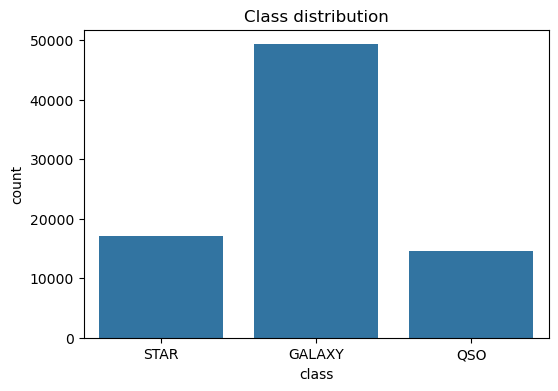

In [60]:
df_classes_pd = df_model_clean.select('class').toPandas()
plt.figure(figsize=(6,4))
sns.countplot(data=df_classes_pd, x="class")
plt.title("Class distribution")
plt.show()

## Undersampling

In [53]:
from pyspark.sql.functions import col
df_stars = df_model_clean.filter(col("class") == "STAR")
df_galaxies = df_model_clean.filter(col("class") == "GALAXY")
df_quasars = df_model_clean.filter(col("class") == "QSO")


In [54]:
print(f"number of instances:\nSTAR: {df_stars.count()}\nGALAXY: {df_galaxies.count()}\nQSO: {df_quasars.count()}")

number of instances:
STAR: 17021
GALAXY: 49269
QSO: 14555


In [55]:
df_stars = df_stars.sample(fraction=0.9)
df_galaxies = df_galaxies.sample(fraction=0.31)

In [56]:
print(f"number of resampled instances:\nSTAR: {df_stars.count()}\nGALAXY: {df_galaxies.count()}\nQSO: {df_quasars.count()}")

number of resampled instances:
STAR: 15303
GALAXY: 15208
QSO: 14555


In [57]:
df_model_clean_resampled = df_stars.union(df_galaxies).union(df_quasars)
df_model_clean_resampled.show(5)

+-----+--------+--------+--------+--------+--------+------------------+-------------------+-------------------+-------------------+---+
|class|       u|       g|       r|       i|       z|               u_g|                g_r|                r_i|                i_z|uid|
+-----+--------+--------+--------+--------+--------+------------------+-------------------+-------------------+-------------------+---+
| STAR|20.79859|19.54183|19.04607|18.82743|18.74658|1.2567599999999999|0.49576000000000064| 0.2186400000000006|0.08084999999999809|  0|
| STAR|19.84112|18.31459|17.70017|17.45584|17.36307| 1.526530000000001| 0.6144199999999991| 0.2443300000000015|0.09276999999999802|  4|
| STAR|24.22564|21.13661|19.62566|  18.859|18.42587|3.0890299999999975| 1.5109500000000011| 0.7666599999999981|  0.433130000000002|  5|
| STAR| 24.9058| 21.5857|20.51728|18.95226|18.38489|            3.3201| 1.0684199999999997| 1.5650200000000005| 0.5673700000000004|  6|
| STAR|21.44778|18.84953|17.72303|17.27145|17.00

## Deviding dataset on test and train sets

In [58]:
train_df, test_df = df_model_clean_resampled.randomSplit([0.8, 0.2], seed=42)

### Plotting distribution of test and train data

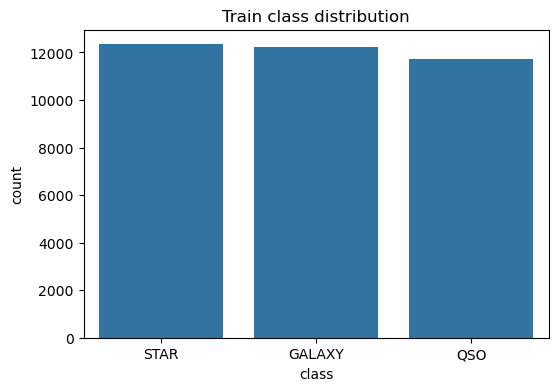

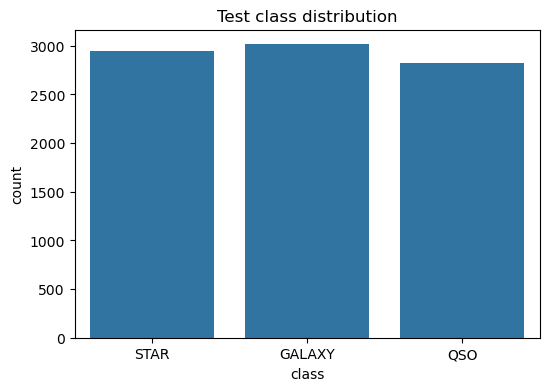

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
train_df_pd = train_df.select("class").toPandas()
test_df_pd = test_df.select("class").toPandas()

plt.figure(figsize=(6,4))
sns.countplot(data=train_df_pd, x="class")
plt.title("Train class distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=test_df_pd, x="class")
plt.title("Test class distribution")
plt.show()

## Creating pipeline shema

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, StandardScaler, VectorAssembler
)

def create_pipeline(model):
    # Vectorizing
    assembler = VectorAssembler(
        inputCols=features,
        outputCol="features"
    )

    # Scalling
    scaler = StandardScaler(
        inputCol="features",
        outputCol="scaled_features",
        withMean=True,    
        withStd=True      
    )

    # Indexing
    indexer = StringIndexer(
        inputCol="class", 
        outputCol="label_index"
    )

    pipeline = Pipeline(stages=[indexer, assembler, scaler, model])

    return pipeline


## Model performance metrices

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def evaluate_model(pred):
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label_index",
        predictionCol="prediction"
    )

    accuracy = evaluator.setMetricName("accuracy").evaluate(pred)
    precision = evaluator.setMetricName("weightedPrecision").evaluate(pred)
    recall = evaluator.setMetricName("weightedRecall").evaluate(pred)
    f1 = evaluator.setMetricName("f1").evaluate(pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [17]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Spark confusion matrix
def conf_matrix(pred, class_names):
    # pred_rdd = pred.select("prediction", "label_index").rdd.map(tuple)
    pred_rdd = pred.select("prediction", "label_index") \
                   .rdd \
                   .map(lambda r: (float(r.prediction), float(r.label_index)))

    metrics = MulticlassMetrics(pred_rdd)
    cm = metrics.confusionMatrix().toArray()

    # Convert to pandas DataFrame
    cm_df = pd.DataFrame(
        cm,
        index=class_names,
        columns=class_names
    )

    # Plot with seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt=".0f",
        cmap="GnBu"
    )

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    return metrics

In [18]:
def class_metrices(metrics, class_names):
    for lbl, name in enumerate(class_names):
        lbl = float(lbl)
        print(f"Class {name}")
        print(f" Precision: {metrics.precision(lbl):.3f}")
        print(f" Recall   : {metrics.recall(lbl):.3f}")
        print(f" F1-score : {metrics.fMeasure(lbl):.3f}")
        print()

In [19]:
from pyspark.ml.feature import StringIndexerModel

def get_class_names(pipeline_model):
    # reading class names form pipeline
    for stage in pipeline_model.stages:
        if isinstance(stage, StringIndexerModel) and stage.getOutputCol() == "label_index":
            class_names = stage.labels
    return class_names

# Classifications

## Random Forest Classifier

In [50]:
from pyspark.ml.classification import RandomForestClassifier

clf = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="label_index"
)

# model = clf.fit(train_df)
# pred = model.transform(test_df)
pipeline_clf = create_pipeline(clf)
model = pipeline_clf.fit(train_df)

In [53]:
pred = model.transform(test_df)

In [54]:
cm = pred.crosstab("label_index", "prediction")
cm.orderBy("label_index_prediction").show()

+----------------------+----+----+----+
|label_index_prediction| 0.0| 1.0| 2.0|
+----------------------+----+----+----+
|                   0.0|1821| 564| 561|
|                   1.0| 175|2690| 149|
|                   2.0| 176| 263|2383|
+----------------------+----+----+----+



Without additional features we obtained:

Accuracy: 0.7204841287965289 

Precision: 0.7176631084159995

Recall: 0.7204841287965289

F1: 0.716742369085459

Accuracy: 0.7850148030061489
Precision: 0.7913237675361164
Recall: 0.785014803006149
F1: 0.7803502788970021


c:\Users\Piotr\anaconda3\envs\BigData\Lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


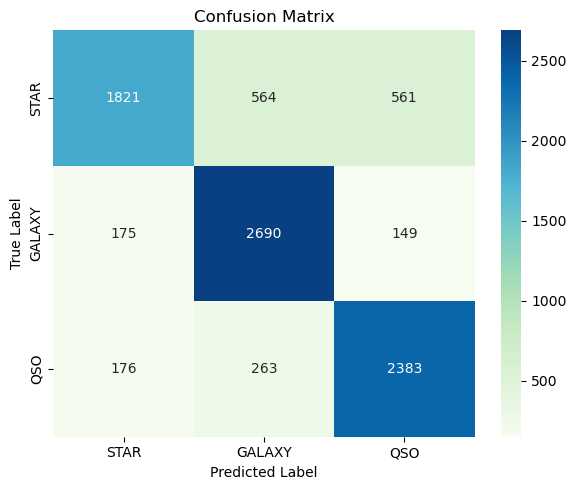

Class STAR
 Precision: 0.838
 Recall   : 0.618
 F1-score : 0.712

Class GALAXY
 Precision: 0.765
 Recall   : 0.893
 F1-score : 0.824

Class QSO
 Precision: 0.770
 Recall   : 0.844
 F1-score : 0.806



In [58]:
evaluate_model(pred)
class_names = get_class_names(model)
metrices = conf_matrix(pred, class_names)
class_metrices(metrices, class_names)

## Neural Network

In [59]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [9, 20, 3]  # input, hidden, output

mlp = MultilayerPerceptronClassifier(
    featuresCol="scaled_features",
    labelCol="label_index",
    layers=layers,
    maxIter=100
)

model = create_pipeline(mlp).fit(train_df)
pred = model.transform(test_df)

In [60]:
cm = pred.crosstab("label_index", "prediction")
cm.orderBy("label_index_prediction").show()

+----------------------+----+----+----+
|label_index_prediction| 0.0| 1.0| 2.0|
+----------------------+----+----+----+
|                   0.0|2207| 324| 415|
|                   1.0| 160|2691| 163|
|                   2.0| 290| 233|2299|
+----------------------+----+----+----+



Accuracy: 0.8195171942609883
Precision: 0.8197713754534832
Recall: 0.8195171942609885
F1: 0.8185027085169008


c:\Users\Piotr\anaconda3\envs\BigData\Lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


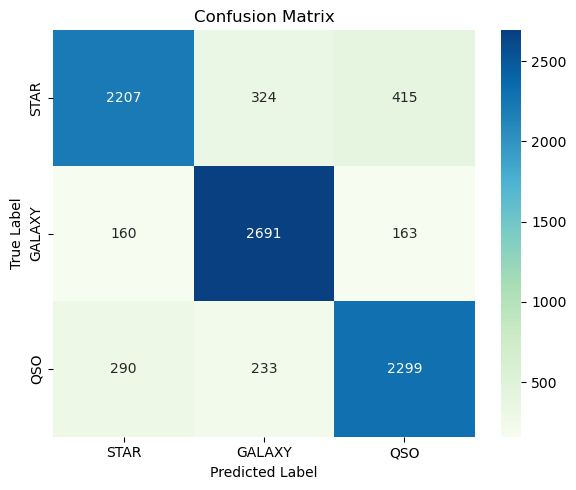

Class STAR
 Precision: 0.831
 Recall   : 0.749
 F1-score : 0.788

Class GALAXY
 Precision: 0.829
 Recall   : 0.893
 F1-score : 0.859

Class QSO
 Precision: 0.799
 Recall   : 0.815
 F1-score : 0.807



In [61]:
evaluate_model(pred)
class_names = get_class_names(model)
metrices = conf_matrix(pred, class_names)
class_metrices(metrices, class_names)

## Hyperparameters optimization

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

mlp = MultilayerPerceptronClassifier(
    featuresCol="scaled_features",
    labelCol="label_index"
)

pipeline = create_pipeline(mlp)

input_dim = 9
num_classes = 3

paramGrid = (ParamGridBuilder()
             .addGrid(mlp.layers, [
                 [input_dim, 20, num_classes],
                 [input_dim, 50, 20, num_classes],
                 [input_dim, 30, 30, num_classes],
                 [input_dim, 30, 20, 10, num_classes]
             ])
             .build())

evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="f1"
)

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

cvModel = cv.fit(train_df)

In [ ]:
best_model = cvModel.bestModel

In [ ]:
best_model.layers

Param(parent='MultilayerPerceptronClassifier_c5405e0245a0', name='layers', doc='Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons.')

In [ ]:
print("Best parameters chosen by CrossValidator:")
print(" layers     :", best_model.layers)
print(" maxIter    :", best_model.getMaxIter())
print(" blockSize  :", best_model.getBlockSize())
print(" stepSize   :", best_model.getStepSize())
print(" tol        :", best_model.getTol())

Best parameters chosen by CrossValidator:
 layers     : MultilayerPerceptronClassifier_c5405e0245a0__layers
 maxIter    : 100
 blockSize  : 128
 stepSize   : 0.03
 tol        : 1e-06


In [ ]:
pred = best_model.transform(test_df)

In [ ]:
cm = pred.crosstab("label_index", "prediction")
cm.orderBy("label_index_prediction").show()

+----------------------+----+----+----+
|label_index_prediction| 0.0| 1.0| 2.0|
+----------------------+----+----+----+
|                   0.0|1916| 746| 289|
|                   1.0| 282|2649|  77|
|                   2.0| 481| 307|2034|
+----------------------+----+----+----+



In [ ]:
evaluate_model(pred)
get_class_names(best_model)
metrics = conf_matrix(pred, class_names)
class_metrices(metrics, class_names)

Accuracy: 0.751508939756292
Precision: 0.7578384276348796
Recall: 0.751508939756292
F1: 0.7495682084117976


In [ ]:
best_model = cvModel.bestModel   # last stage is the MLP model
print(best_model.getLayers())

[9, 20, 3]


# GBT Classifier

In [19]:
from pyspark.ml.classification import GBTClassifier


gbt = GBTClassifier(
    featuresCol="scaled_features",
    labelCol="label_index",
    maxIter=100,          # number of trees
    maxDepth=5,           # tree depth
    stepSize=0.1,         # learning rate
    subsamplingRate=0.8,  # row sampling
    seed=42
)

from pyspark.ml.classification import OneVsRest

ovr = OneVsRest(
    classifier=gbt,
    labelCol="label_index",
    featuresCol="scaled_features"
)



In [ ]:
pipeline_model = create_pipeline(ovr).fit(train_df)

pred_gbt = pipeline_model.transform(test_df)

In [ ]:
evaluate_model(pred_gbt)
class_names = get_class_names(pipeline_model)
metrics = conf_matrix(pred_gbt, class_names)
class_metrices(metrics, class_names)

Accuracy: 0.8574696865705788
Precision: 0.8575566014138832
Recall: 0.8574696865705789
F1: 0.8569119540134784


In [59]:
from pyspark.ml import PipelineModel

pipeline_model = PipelineModel.load("full_pipeline_model")

Exception ignored in: <function JavaModelWrapper.__del__ at 0x000001F1F1738EA0>
Traceback (most recent call last):
  File "c:\Users\Piotr\anaconda3\envs\BigData\Lib\site-packages\pyspark\mllib\common.py", line 152, in __del__
    assert self._sc._gateway is not None
           ^^^^^^^^
AttributeError: 'MulticlassMetrics' object has no attribute '_sc'


In [60]:
pred_gbt = pipeline_model.transform(test_df)

Accuracy: 0.8508211678832117
Precision: 0.8511134198142685
Recall: 0.8508211678832116
F1: 0.8502099297375901


c:\Users\Piotr\anaconda3\envs\BigData\Lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


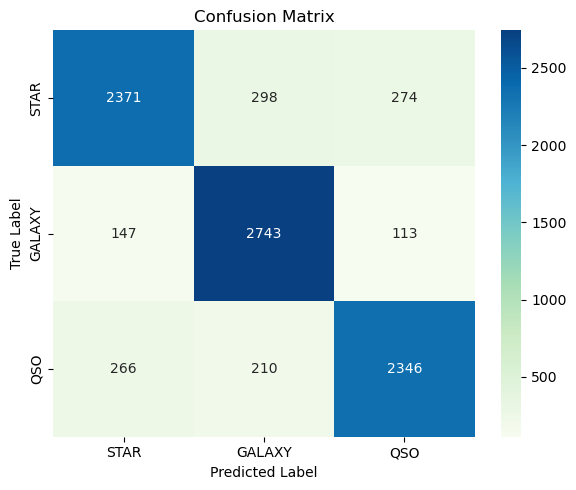

Class STAR
 Precision: 0.852
 Recall   : 0.806
 F1-score : 0.828

Class GALAXY
 Precision: 0.844
 Recall   : 0.913
 F1-score : 0.877

Class QSO
 Precision: 0.858
 Recall   : 0.831
 F1-score : 0.845



In [61]:

evaluate_model(pred_gbt)
class_names = get_class_names(pipeline_model)
metrics = conf_matrix(pred_gbt, class_names)
class_metrices(metrics, class_names)

## Oversampling

In [20]:
features

['u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z']

In [21]:

df_model_clean.groupBy("class").count().show()


+------+-----+
| class|count|
+------+-----+
|GALAXY|49269|
|   QSO|14555|
|  STAR|17021|
+------+-----+



### Creating balanced test set

In [22]:
from pyspark.sql.functions import col, rand
from pyspark.sql.functions import col, rand, monotonically_increasing_id

# Add unique ID to dataset
df_model_clean = df_model_clean.withColumn("uid", monotonically_increasing_id())

test_per_class = 3500   # number of samples per class in test set

# -----------------------------
# Step 1: Compute fractions for sampleBy
# -----------------------------
# fractions = test_per_class / count per class
class_counts = df_model_clean.groupBy("class").count().collect()
fractions = {row['class']: test_per_class / row['count'] for row in class_counts}

# -----------------------------
# Step 2: Sample test set (distributed)
# -----------------------------
test_df_balanced = df_model_clean.sampleBy("class", fractions, seed=42)

# Shuffle the test set
test_df_balanced = test_df_balanced.orderBy(rand())
test_df_balanced.show(5)

+------+--------+--------+--------+--------+--------+--------------------+-------------------+-------------------+-------------------+-----------+
| class|       u|       g|       r|       i|       z|                 u_g|                g_r|                r_i|                i_z|        uid|
+------+--------+--------+--------+--------+--------+--------------------+-------------------+-------------------+-------------------+-----------+
|   QSO|22.45267| 21.8079|21.52492| 20.9204|21.70894|  0.6447700000000012|0.28297999999999845| 0.6045200000000008|-0.7885399999999976|       3866|
|   QSO|21.37863|21.86633|21.33547| 21.5923|22.79166|-0.48770000000000024| 0.5308600000000006|-0.2568300000000008|-1.1993599999999986|      10097|
|   QSO|22.81505|21.60515|20.50366|19.74769|19.38567|   1.209900000000001| 1.1014899999999983| 0.7559700000000014|0.36201999999999757|      15767|
|GALAXY|22.24447| 22.0783|20.55557|19.70287|19.51169| 0.16617000000000104| 1.5227299999999993| 0.8526999999999987|0.19

Creating train set

In [23]:
train_df_balanced = df_model_clean.join(
    test_df_balanced.select("uid"),
    on="uid",
    how="left_anti"
)

In [24]:
train_df_balanced.groupBy("class").count().show()
test_df_balanced.groupBy("class").count().show()

+------+-----+
| class|count|
+------+-----+
|GALAXY|45730|
|   QSO|11087|
|  STAR|13446|
+------+-----+

+------+-----+
| class|count|
+------+-----+
|GALAXY| 3539|
|   QSO| 3468|
|  STAR| 3575|
+------+-----+



In [25]:
# Step 1: find max count
class_counts = train_df_balanced.groupBy("class").count().collect()
max_count = max([row['count'] for row in class_counts])

# Step 2: oversample
oversampled_dfs = []

for row in class_counts:
    cls = row['class']
    count_cls = row['count']
    
    df_cls = train_df_balanced.filter(col("class") == cls)
    
    if count_cls < max_count:
        # sample with replacement
        ratio = int(max_count / count_cls)
        remainder = max_count % count_cls
        
        oversampled_df = df_cls
        for _ in range(ratio - 1):  # already have original
            oversampled_df = oversampled_df.union(df_cls)
        
        if remainder > 0:
            oversampled_df = oversampled_df.union(df_cls.sample(withReplacement=True, fraction=remainder/count_cls, seed=42))
        
        oversampled_dfs.append(oversampled_df)
    else:
        oversampled_dfs.append(df_cls)

# Step 3: combine all classes
train_df_balanced = oversampled_dfs[0]
for df in oversampled_dfs[1:]:
    train_df_balanced = train_df_balanced.union(df)

# Shuffle the rows
train_df_balanced = train_df_balanced.orderBy(rand())

In [26]:
train_df_balanced.groupBy("class").count().show()

+------+-----+
| class|count|
+------+-----+
|GALAXY|46638|
|   QSO|56075|
|  STAR|54301|
+------+-----+



In [27]:
train_df_balanced.select("*").show(5)

+----------+------+--------+--------+--------+--------+--------+-------------------+--------------------+--------------------+--------------------+
|       uid| class|       u|       g|       r|       i|       z|                u_g|                 g_r|                 r_i|                 i_z|
+----------+------+--------+--------+--------+--------+--------+-------------------+--------------------+--------------------+--------------------+
|      1324|GALAXY|22.54841|21.55063|19.79975|18.76388|18.28457| 0.9977799999999988|  1.7508800000000022|  1.0358699999999992|  0.4793100000000017|
|8589935630|   QSO|21.56084|20.99444|20.82183|20.87439|20.58956|  0.566399999999998| 0.17261000000000237|-0.05255999999999972|  0.2848299999999995|
|     38329|   QSO|21.83685|21.76931|21.98779|21.58626|21.99235|0.06753999999999749|-0.21847999999999956| 0.40153000000000105|-0.40608999999999895|
|8589967890|  STAR|21.75529|20.59718|20.14365|19.95131|20.37363|  1.158109999999997| 0.45353000000000065|  0.192

In [28]:
test_df_balanced.select("*").show(5)


+------+--------+--------+--------+--------+--------+--------------------+-------------------+-------------------+-------------------+-----------+
| class|       u|       g|       r|       i|       z|                 u_g|                g_r|                r_i|                i_z|        uid|
+------+--------+--------+--------+--------+--------+--------------------+-------------------+-------------------+-------------------+-----------+
|   QSO|22.45267| 21.8079|21.52492| 20.9204|21.70894|  0.6447700000000012|0.28297999999999845| 0.6045200000000008|-0.7885399999999976|       3866|
|   QSO|21.37863|21.86633|21.33547| 21.5923|22.79166|-0.48770000000000024| 0.5308600000000006|-0.2568300000000008|-1.1993599999999986|      10097|
|   QSO|22.81505|21.60515|20.50366|19.74769|19.38567|   1.209900000000001| 1.1014899999999983| 0.7559700000000014|0.36201999999999757|      15767|
|GALAXY|22.24447| 22.0783|20.55557|19.70287|19.51169| 0.16617000000000104| 1.5227299999999993| 0.8526999999999987|0.19

## Classifications

In [29]:
from pyspark.ml.classification import RandomForestClassifier

clf = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="label_index"
)


pipeline_clf = create_pipeline(clf)
model = pipeline_clf.fit(train_df_balanced)

In [30]:
pred = model.transform(test_df_balanced)

Accuracy: 0.7938952938952939
Precision: 0.7966958130495894
Recall: 0.7938952938952939
F1: 0.7912706839292094


c:\Users\Piotr\anaconda3\envs\BigData\Lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


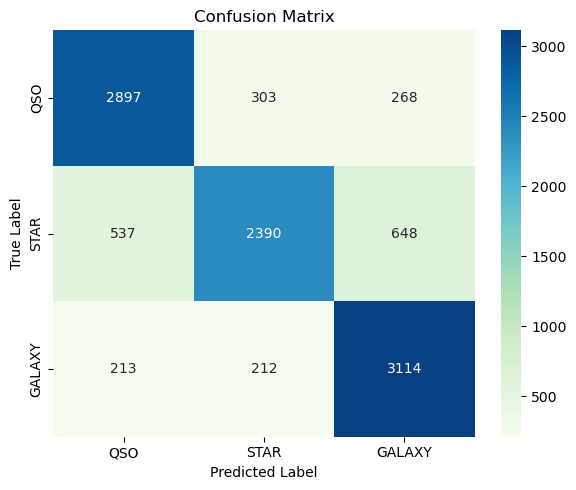

Class QSO
 Precision: 0.794
 Recall   : 0.835
 F1-score : 0.814

Class STAR
 Precision: 0.823
 Recall   : 0.669
 F1-score : 0.738

Class GALAXY
 Precision: 0.773
 Recall   : 0.880
 F1-score : 0.823



In [31]:
evaluate_model(pred)
class_names = get_class_names(model)
metrices = conf_matrix(pred, class_names)
class_metrices(metrices, class_names)

For Smote:

Accuracy: 0.7889812889812889

Precision: 0.7946935826587673

Recall: 0.788981288981289

F1: 0.7854819456774271


### GBT

In [41]:
from pyspark.ml.classification import GBTClassifier


gbt = GBTClassifier(
    featuresCol="scaled_features",
    labelCol="label_index",
    maxIter=100,          # number of trees
    maxDepth=5,           # tree depth
    stepSize=0.1,         # learning rate
    subsamplingRate=0.8,  # row sampling
    seed=42
)

from pyspark.ml.classification import OneVsRest

ovr = OneVsRest(
    classifier=gbt,
    labelCol="label_index",
    featuresCol="scaled_features"
)


pipeline_model = create_pipeline(ovr).fit(train_df_balanced)



In [42]:
pipeline_model.write().overwrite().save("pipeline_model_GBT_oversample")

In [43]:
pred_gbt = pipeline_model.transform(test_df_balanced)

In [34]:
evaluate_model(pred_gbt)

Accuracy: 0.8544698544698545
Precision: 0.8545492417540018
Recall: 0.8544698544698545
F1: 0.8540986108659362


In [35]:
from pyspark.ml import PipelineModel

pipeline_model = PipelineModel.load("pipeline_model_GBT_oversample")
pred_gbt = pipeline_model.transform(test_df_balanced)
evaluate_model(pred_gbt)
# class_names = get_class_names(pipeline_model)
# metrics = conf_matrix(pred_gbt, class_names)
# class_metrices(metrics, class_names)

Accuracy: 0.8544698544698545
Precision: 0.8545492417540018
Recall: 0.8544698544698545
F1: 0.8540986108659362
